<h1><center>Title of the Project</center></h1>

CMSC 320 Fall 2022 Final Project   
Group members: Christopher Antar, Shilin Huang

# Introduction
According to the data from The American Society for the [Prevention of Cruelty to Animals® (ASPCA®)](https://www.aspca.org/helping-people-pets/shelter-intake-and-surrender/pet-statistics), approximately 6.3 million companion animals enter U.S. animal shelters nationwide every year and the most common pets are dogs and cats; approximately 4.1 million shelter animals are adopted each year.  
When selecting pets, people would consider a lot of factors including their physical appearance, age, breeds or trends in the popularity of certain breeds, behavior, personalities, health, and so on. We are curious about how different factors would influence people’s choices.
Therefore, the purpose of this project is to find what animal is most likely to be adopted. We will create seperate spreadsheets for dogs and cats and then analyze their age, breed, ...

We will begin by importing packages that help data processing, plot making, and classification.

In [1]:
import datetime as dt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd 
import re
import warnings
warnings.filterwarnings('ignore')

The following functions help us process the data.

In [2]:
# This function helps add a new column for age ranges
# You need to put the age of the animal in the parameter
# the function will return a String indicating the age group of the animal

def get_age_group(age):
    if age < 90:
        return "0-3 months"
    elif age <=365:
        return "3-12 months"
    elif age <= 731:
        return "1-2 Years"
    elif age <= 1825:
        return "2-5 Years"
    else:
        return "5+ Years"

In [3]:
# This function helps changing the datatime to corresponding seasons
# You need to put the date with type String in the parameter
# the function will return an integer indicating the season
# Spring = 1, Summer = 2, Autumn = 3, Winter = 4
# We used information on this website to transform dates to seasons
# https://www.timeanddate.com/calendar/aboutseasons.html

def date_to_season(date):
    month = int(re.compile(r"[0-9]{4}-([0-9]{2})-").match(date).group(1))

    # Spring
    if 3 <= month and month <= 5:
        return 1
    # Summer
    elif 6 <= month and month <= 8:
        return 2
    # Autumn
    elif 9 <= month and month <= 11:
        return 3
    # Winter
    elif month == 12 or month == 1 or month == 2:
        return 4

# Data Collection and Preliminary Data Cleaning

In [4]:
# read in the dataset
df = pd.read_csv("train.csv", index_col = 0)

# remove unnecessary columns and rows
df.drop("Name", axis = 1, inplace=True)
df.drop("OutcomeSubtype", axis = 1, inplace=True)
df.drop(df[df.OutcomeType == "Died"].index, inplace=True)
df.drop(df[df.OutcomeType == "Return_to_owner"].index, inplace=True)

# add a column to show whether the animal was adopted, 1 indicates True and 0 indicates False
df["Adopted"] = df.apply(lambda row: 1 if row["OutcomeType"] == "Adoption" else 0 , axis=1)

# change column names
df.rename({"AgeuponOutcome": "AgeuponOutcome(day)"}, axis=1, inplace=True)
df.rename({"DateTime": "Season"}, axis=1, inplace=True)

# iterate through the dataframe to process the data
for index, row in df.iterrows():
    
    # change age to days, assume there are 365 days in a year and 30 days in a month.
    try:
        num = int(re.compile(r"[0-9]+").match(row["AgeuponOutcome(day)"]).group(0))
        
        if "year" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = int(num * 365)
        elif "month" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num * 30
        elif "week" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num * 7
        elif "day" in row["AgeuponOutcome(day)"]:
            df.at[index,"AgeuponOutcome(day)"] = num
    except:
        continue
        # there are about 20 missing data
        
    # change datetime to season
    # Spring = 1, Summer = 2, Autumn = 3, Winter = 4
    df.at[index,"Season"] = date_to_season(row["Season"])
    
    
# Create age bins
df['AgeGroup'] = df["AgeuponOutcome(day)"].apply(get_age_group)

# show the cleaned dataframe
display(df)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A656520,3,Euthanasia,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,0,3-12 months
A686464,4,Adoption,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,1,1-2 Years
A683430,2,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,0,0-3 months
A667013,3,Transfer,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,0,1-2 Years
A677334,1,Transfer,Dog,Intact Female,30,Cairn Terrier/Chihuahua Shorthair,Black/Tan,0,0-3 months
...,...,...,...,...,...,...,...,...,...
A702446,1,Transfer,Cat,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,0,0-3 months
A718934,4,Transfer,Cat,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,0,3-12 months
A698128,1,Adoption,Dog,Neutered Male,1460,Old English Bulldog Mix,White/Tan,1,2-5 Years


We separate the data into two parts based on the species.

In [5]:
# create seperate dataframes for dogs and cats
grouped = df.groupby(df.AnimalType)
dogs = grouped.get_group("Dog")
cats = grouped.get_group("Cat")

### Data Cleaning for Dogs  
Replace all / with "Mutt", there are over 1300 breeds to start, this narrows it down to 300. 
It is very common for adoption shelters to label random mutts as two popular breeds so the dog will be more likely to be adopted.

In [6]:
dogs['Breed'] = dogs.Breed.str.replace(r'(^.*/.*$)', 'Mutt', regex=True)
#dogs.loc['Breed'] = dogs['Breed'].str.replace(r'(^.*/.*$)', 'Mutt')

In [7]:
display(dogs)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A686464,4,Adoption,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,1,1-2 Years
A667013,3,Transfer,Dog,Neutered Male,730,Mutt,Tan,0,1-2 Years
A677334,1,Transfer,Dog,Intact Female,30,Mutt,Black/Tan,0,0-3 months
A671784,4,Adoption,Dog,Spayed Female,150,American Pit Bull Terrier Mix,Red/White,1,3-12 months
A677747,1,Adoption,Dog,Spayed Female,365,Cairn Terrier,White,1,3-12 months
...,...,...,...,...,...,...,...,...,...
A708833,2,Adoption,Dog,Spayed Female,60,Pointer Mix,Black/White,1,0-3 months
A697158,1,Adoption,Dog,Neutered Male,60,Newfoundland Mix,White/Black,1,0-3 months
A701044,1,Adoption,Dog,Neutered Male,60,Mutt,Black/Tricolor,1,0-3 months


In [8]:
display(cats)

,Season,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome(day),Breed,Color,Adopted,AgeGroup
AnimalID,,,,,,,,,
A656520,3,Euthanasia,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,0,3-12 months
A683430,2,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,0,0-3 months
A699218,1,Transfer,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Tabby,0,0-3 months
A701489,1,Transfer,Cat,Unknown,21,Domestic Shorthair Mix,Brown Tabby,0,0-3 months
A668402,4,Transfer,Cat,Unknown,730,Domestic Shorthair Mix,Black,0,1-2 Years
...,...,...,...,...,...,...,...,...,...
A687056,2,Transfer,Cat,Intact Male,150,Domestic Shorthair Mix,Orange Tabby,0,3-12 months
A702446,1,Transfer,Cat,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,0,0-3 months
A718934,4,Transfer,Cat,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,0,3-12 months


# Data Visualization and Analysis

## Graph 1
The two pie charts shows the percentage of dogs and cats adopted respectively.

We can see that 6497 dogs were adopted, and 4762 were not.
We can see that 4272 cats were adopted, and 6215 were not.


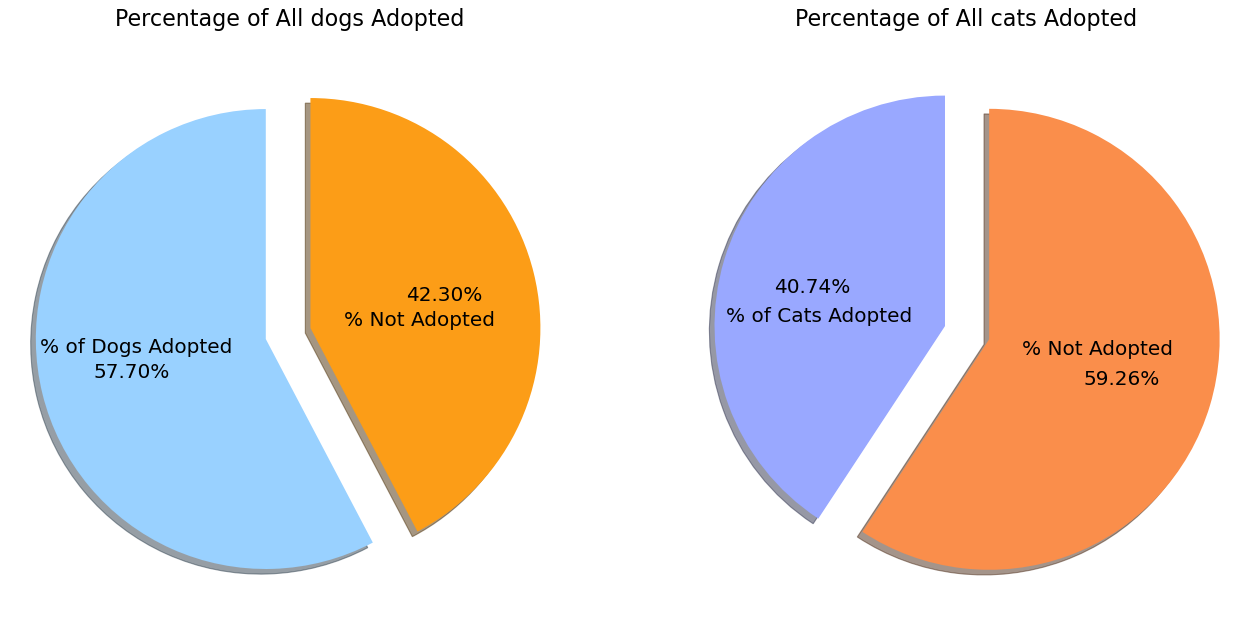

In [9]:
adopt_dog = dogs["Adopted"].value_counts()
print("We can see that", adopt_dog[1] , "dogs were adopted, and", 
      adopt_dog[0], "were not.")

adopt_cat = cats["Adopted"].value_counts()
print("We can see that", adopt_cat[1], "cats were adopted, and", 
            adopt_cat[0], "were not.")

figure(figsize=(20, 10), dpi=80)
   
#Dogs vs Cats Pie Charts
    
# plot for dogs
labels= ['% of Dogs Adopted', '% Not Adopted']
sizes = [adopt_dog[1], adopt_dog[0]]
ax = plt.subplot(1,2,1)
plt.pie(sizes,labels=labels, colors=["#99d1ff", "#fc9d17"], startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%', 
        textprops={'fontsize': 18}, labeldistance= 0.15)
plt.title('Percentage of All dogs Adopted', fontsize = '20')
plt.axis('equal')

# plot for cats
labels= ['% of Cats Adopted', '% Not Adopted']
sizes = [adopt_cat[1], adopt_cat[0]]
ax = plt.subplot(1,2,2)
plt.pie(sizes,labels=labels, colors=["#99a8ff", "#fa8e4b"], startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%', 
        textprops={'fontsize': 18}, labeldistance= 0.15)
plt.title('Percentage of All cats Adopted', fontsize = '20')
plt.axis('equal')

plt.show()

## Graph 2
This bar charts show the percepntage of dogs and cats adopted for different groups of ages.

In [10]:
#Create bins for dogs 
dogs['AgeGroup'] = dogs["AgeuponOutcome(day)"].apply(get_age_group)
#This is out of order because value counts will go be highest number
dog_age_groups = ["3-12 months",  "1-2 Years", "2-5 Years", "0-3 months",  "5+ Years"]
age_groups_in_order = ["0-3 months", "3-12 months",  "1-2 Years", "2-5 Years", "5+ Years"]
dog_age_group_totals = dogs['AgeGroup'].value_counts().tolist()
dpercentages = [0] * 5

for i in range(5):
    adopted = len(dogs[(dogs['Adopted'] == 1) & (dogs['AgeGroup'] == dog_age_groups[i] )])
    dpercentages[i] = float(adopted / dog_age_group_totals[i])
dog_percentages_in_order = [dpercentages[3],dpercentages[0],dpercentages[1],dpercentages[2],dpercentages[4]]

In [11]:
#Create bins for cats 
cats['Age Group'] = cats["AgeuponOutcome(day)"].apply(get_age_group)
# This is out of order because value counts will go be highest number
cat_age_groups = ["0-3 months", "3-12 months",  "1-2 Years", "5+ Years", "2-5 Years"]
cat_age_group_totals = cats['Age Group'].value_counts().tolist()
cpercentages = [0] * 5

for i in range(5):
    adopted = len(cats[(cats['Adopted'] == 1) & (cats['AgeGroup'] == cat_age_groups[i] )])
    cpercentages[i] = float(adopted / cat_age_group_totals[i])
cat_percentages_in_order = [cpercentages[3],cpercentages[0],cpercentages[1],cpercentages[2],cpercentages[4]]

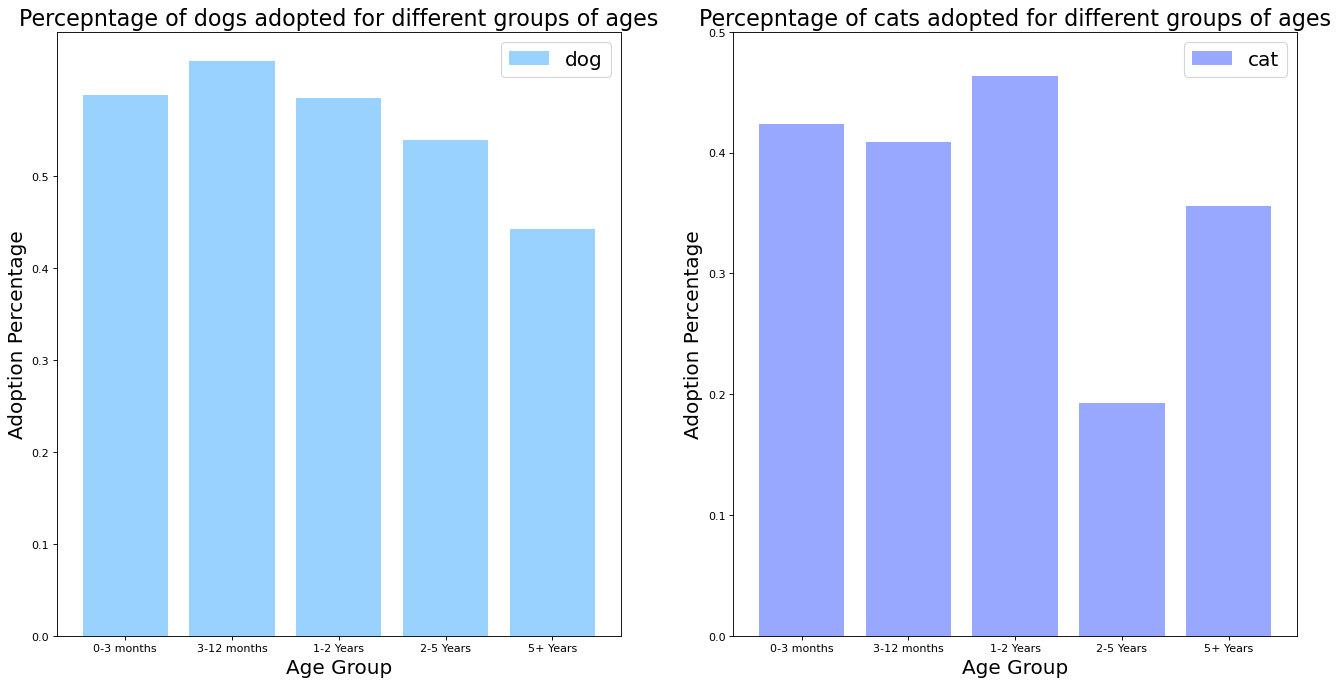

In [12]:
#Dogs vs Cats Bar Charts
figure(figsize=(20, 10), dpi=80)

# plot for dogs
ax = plt.subplot(1,2,1)
plt.bar(age_groups_in_order, dog_percentages_in_order, color = "#99d1ff")
plt.title('Percepntage of dogs adopted for different groups of ages', fontsize = '20')
plt.xlabel('Age Group', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.6, 0.1)
plt.yticks(listOf_Yticks)
plt.legend(["dog"], fontsize=18)

# plot for cats
ax = plt.subplot(1,2,2)
plt.bar(age_groups_in_order, cat_percentages_in_order, color = "#99a8ff")
plt.title('Percepntage of cats adopted for different groups of ages', fontsize = '20')
plt.xlabel('Age Group', fontsize = '18')
plt.ylabel('Adoption Percentage', fontsize = '18')
listOf_Yticks = np.arange(0, 0.6, 0.1)
plt.yticks(listOf_Yticks)
plt.legend(["cat"], fontsize=18)
plt.show()

## Graph 3
Bar charts showing the adoption percentages by breed

In [13]:
# Dog breeds
print(dogs['Breed'].value_counts())

Mutt                                  2382
Chihuahua Shorthair Mix               1346
Pit Bull Mix                          1303
Labrador Retriever Mix                 990
German Shepherd Mix                    408
                                      ... 
Nova Scotia Duck Tolling Retriever       1
Norfolk Terrier                          1
Hovawart Mix                             1
American Eskimo                          1
Beauceron                                1
Name: Breed, Length: 277, dtype: int64


We are going to take the 15 most popular dog breeds and calculate their adoption percentage.
From the value counts the following breeds are the most popular dogs, each with over 100 rows of points in the table.

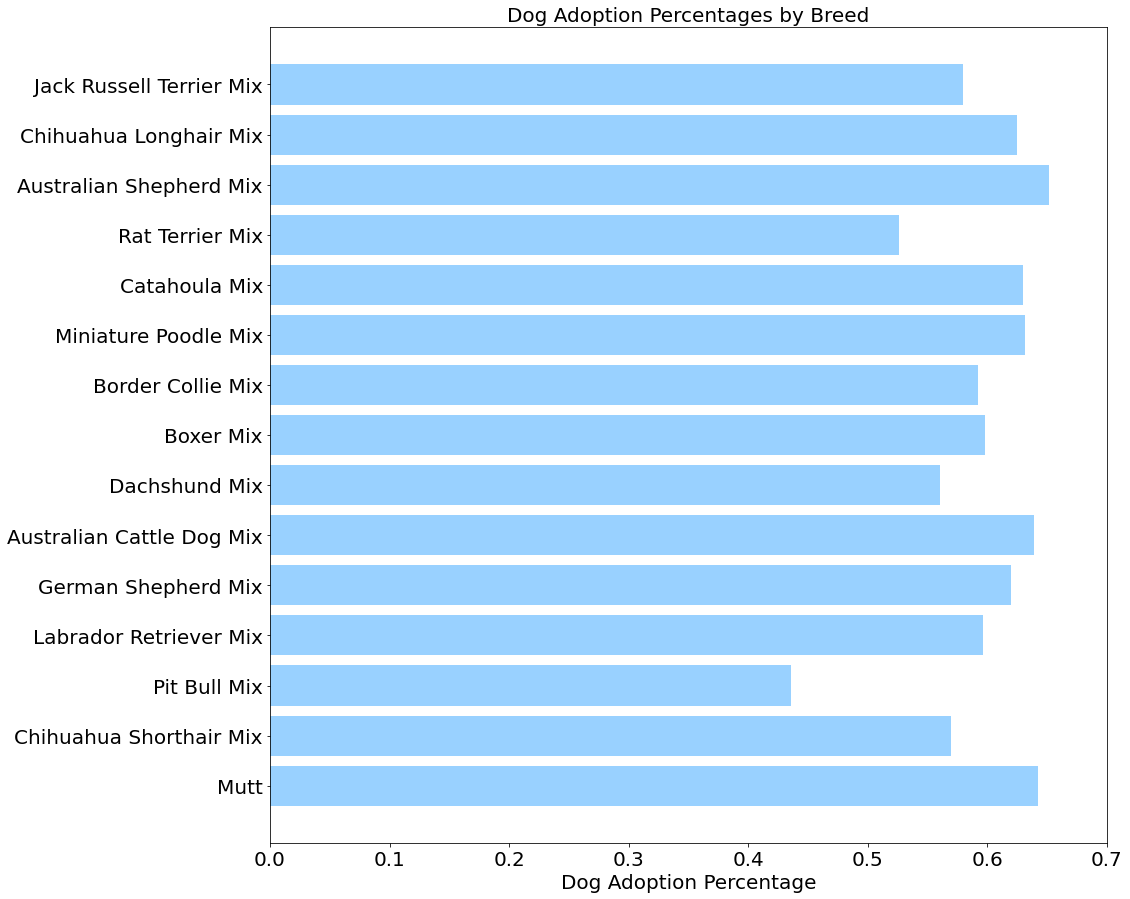

In [14]:
# make a plot
dog_breeds = ["Mutt","Chihuahua Shorthair Mix","Pit Bull Mix","Labrador Retriever Mix","German Shepherd Mix",
          "Australian Cattle Dog Mix","Dachshund Mix","Boxer Mix","Border Collie Mix","Miniature Poodle Mix","Catahoula Mix",
          "Rat Terrier Mix","Australian Shepherd Mix","Chihuahua Longhair Mix","Jack Russell Terrier Mix"]
dog_breed_totals = dogs['Breed'].value_counts().tolist()
dog_breed_totals = dog_breed_totals[0:15]
dog_breed_adoption_percentages = [0] * 15

# Calculating adoption percentages for breeds
for i in range(15):
    adopted = len(dogs[(dogs['Adopted'] == 1) & (dogs['Breed'] == dog_breeds[i])])
    dog_breed_adoption_percentages[i] = float(adopted / dog_breed_totals[i])

plt.figure(figsize=(15,15)) 
plt.barh(np.arange(len(dog_breeds)), dog_breed_adoption_percentages, align='center',color=["#99d1ff"])
plt.yticks(np.arange(len(dog_breeds)), labels=dog_breeds, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Dog Adoption Percentage', fontsize=20)
plt.title('Dog Adoption Percentages by Breed', fontsize=20)
listOf_Xticks = np.arange(0, 0.8, 0.1)
plt.xticks(listOf_Xticks)

plt.show()

In [15]:
# Cat breeds
print(cats['Breed'].value_counts())

Domestic Shorthair Mix                     8346
Domestic Medium Hair Mix                    802
Domestic Longhair Mix                       460
Siamese Mix                                 357
Domestic Shorthair                          128
Snowshoe Mix                                 70
Domestic Medium Hair                         42
Manx Mix                                     41
Maine Coon Mix                               40
Russian Blue Mix                             24
Siamese                                      24
Domestic Longhair                            23
Himalayan Mix                                12
Siamese/Domestic Shorthair                   11
Persian Mix                                  11
Ragdoll Mix                                  10
American Shorthair Mix                        8
Angora Mix                                    6
Japanese Bobtail Mix                          6
Balinese Mix                                  5
Bombay Mix                              

For cats, we will only take the 10 most popular cat breeds and calculate their adoption percentage, because we want to have at least 70 rows of data to make our analysis more reliable.

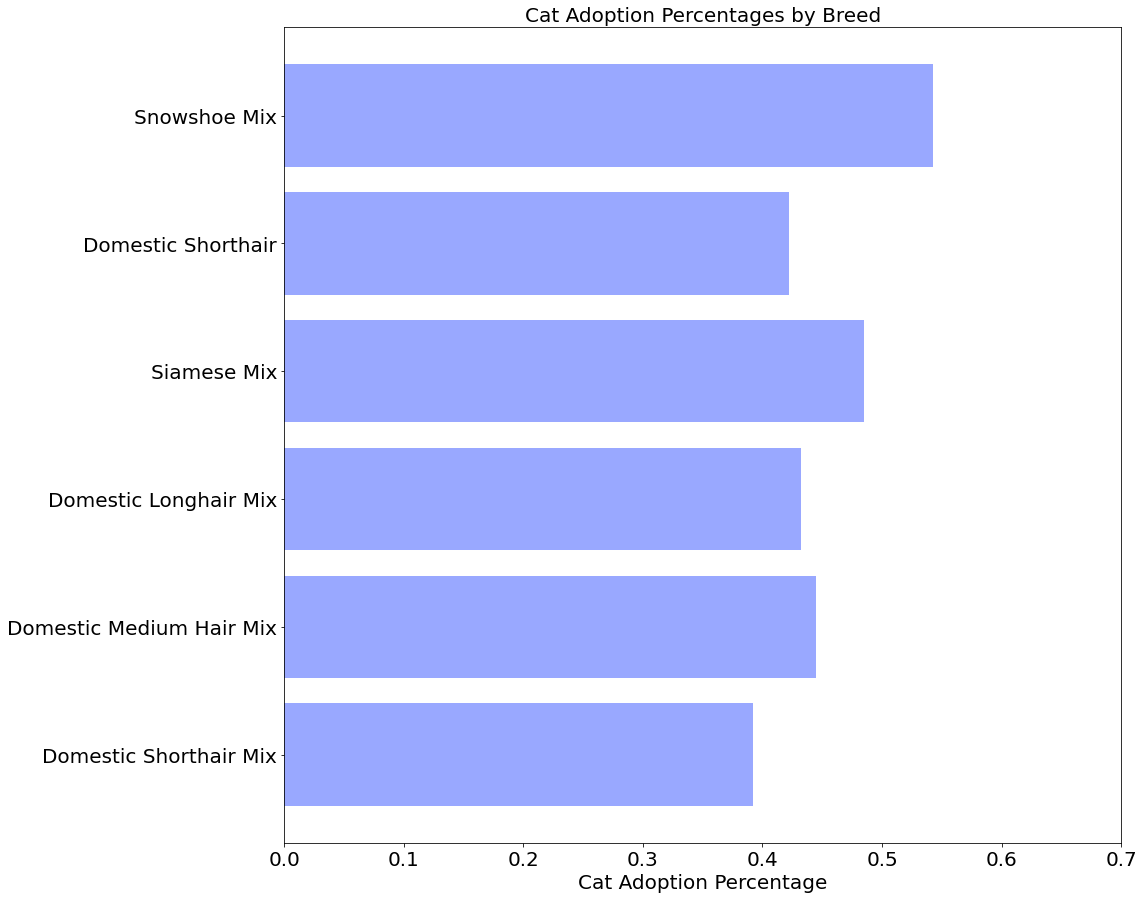

In [17]:
# make a plot
cat_breeds = ["Domestic Shorthair Mix", "Domestic Medium Hair Mix", "Domestic Longhair Mix", "Siamese Mix",
              "Domestic Shorthair", "Snowshoe Mix"]
cat_breed_totals = cats['Breed'].value_counts().tolist()
cat_breed_totals = cat_breed_totals[0:6]
cat_breed_adoption_percentages = [0] * 6

# Calculating adoption percentages for breeds
for i in range(6):
    adopted = len(cats[(cats['Adopted'] == 1) & (cats['Breed'] == cat_breeds[i])])
    cat_breed_adoption_percentages[i] = float(adopted / cat_breed_totals[i])

plt.figure(figsize=(15,15)) 
plt.barh(np.arange(len(cat_breeds)), cat_breed_adoption_percentages, align='center',color=["#99a8ff"])
plt.yticks(np.arange(len(cat_breeds)), labels=cat_breeds, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Cat Adoption Percentage', fontsize=20)
plt.title('Cat Adoption Percentages by Breed', fontsize=20)
listOf_Xticks = np.arange(0, 0.8, 0.1)
plt.xticks(listOf_Xticks)

plt.show()

# Classification


# Conclusion
